In [5]:
import torch
import torchaudio
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import yaml
from easydict import EasyDict
import pandas as pd


In [22]:
root=Path('/Users/nellygarcia/Documents/InformationRetrivalPhd/Dataset')
with open('/Users/nellygarcia/Documents/InformationRetrivalPhd/config.yaml') as conf:
    cfg = EasyDict(yaml.safe_load(conf))

print(cfg)
print()
print('You can overwrite parameters here, example:')
print('cfg.clip_length = 1.0')


{'clip_length': 5.0, 'sample_rate': 44100, 'hop_length': 512, 'n_fft': 1024, 'n_mels': 64, 'f_min': 0, 'f_max': 22050}

You can overwrite parameters here, example:
cfg.clip_length = 1.0


In [29]:
# Load example wave.
data_files = sorted(root.glob('**/*.wav'))
print(f'Training set has {len(data_files)} files. First file:', data_files[0])
waveform, sr = torchaudio.load(data_files[0])
# plt.plot(waveform.t().numpy()); plt.show()
# print('Listen to the first 5 second.')
Audio(waveform[0, :sr], rate=sr)

Training set has 1911 files. First file: /Users/nellygarcia/Documents/InformationRetrivalPhd/Dataset/Applause/f_n_Applause1-16.wav


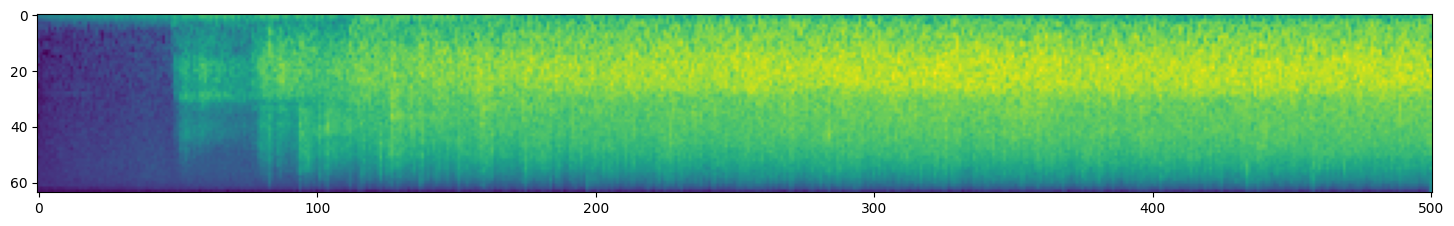

In [10]:
# Instantiate mel spectrogram converter 
to_mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=cfg.sample_rate, n_fft=cfg.n_fft, n_mels=cfg.n_mels,
    hop_length=cfg.hop_length, f_min=cfg.f_min, f_max=cfg.f_max)

# Waveform to log-mel spectrogram
log_mel_spec = to_mel_spectrogram(waveform).log()

plt.figure(figsize=(18,5))
plt.imshow(log_mel_spec[0])

Getting the mel spectrogram from all the dataset

In [8]:
root=Path('/Users/nellygarcia/Documents/InformationRetrivalPhd/Dataset')
data_files = sorted(root.glob('**/*.wav')
                    )

with open('/Users/nellygarcia/Documents/InformationRetrivalPhd/config.yaml') as conf:
    cfg = EasyDict(yaml.safe_load(conf))

print(cfg)
to_mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=44100, n_fft=1024, n_mels=64,
    hop_length=512, f_min=0, f_max=22050)

for file in data_files:
    try:
        # Load waveform
        waveform, sr = torchaudio.load(file)
        
        # Check if the sample rate is correct
        if sr != 44100:
            print(f"Skipping {file} due to incorrect sample rate.")
            continue
        
        # Generate log Mel spectrogram
        log_mel_spec = to_mel_spectrogram(waveform).log()
        
        # Create output directory if it does not exist
        output_dir = root / 'Processed'
        output_dir.mkdir(parents=True, exist_ok=True)
        
        # Save the log Mel spectrogram
        output_file = output_dir / file.with_suffix('.npy').name
        np.save(output_file, log_mel_spec.numpy())
        
        print(f"Processed {file}")
    
    except Exception as e:
        print(f"Failed to process {file}: {e}")

{'clip_length': 5.0, 'sample_rate': 44100, 'hop_length': 512, 'n_fft': 1024, 'n_mels': 64, 'f_min': 0, 'f_max': 22050}
Processed /Users/nellygarcia/Documents/InformationRetrivalPhd/Dataset/Applause/f_n_Applause1-16.wav
Processed /Users/nellygarcia/Documents/InformationRetrivalPhd/Dataset/Applause/f_n_Applause10-16.wav
Processed /Users/nellygarcia/Documents/InformationRetrivalPhd/Dataset/Applause/f_n_Applause11-16.wav
Processed /Users/nellygarcia/Documents/InformationRetrivalPhd/Dataset/Applause/f_n_Applause12-16.wav
Processed /Users/nellygarcia/Documents/InformationRetrivalPhd/Dataset/Applause/f_n_Applause13-16.wav
Processed /Users/nellygarcia/Documents/InformationRetrivalPhd/Dataset/Applause/f_n_Applause14-16.wav
Processed /Users/nellygarcia/Documents/InformationRetrivalPhd/Dataset/Applause/f_n_Applause15-16.wav
Processed /Users/nellygarcia/Documents/InformationRetrivalPhd/Dataset/Applause/f_n_Applause16-16.wav
Processed /Users/nellygarcia/Documents/InformationRetrivalPhd/Dataset/Appl

In [9]:
# Shows number of files converted
!ls -1R {root} | grep .npy | wc -l

    1616


Confirmation of the melspec

/var/folders/2h/jy0nwy2n2fx6qstqzgvxc6k80000gn/T/ipykernel_1947/2482336507.py:14: RuntimeWarning: invalid value encountered in log10
  log_mel_spec_db = 10 * np.log10(log_mel_spec)


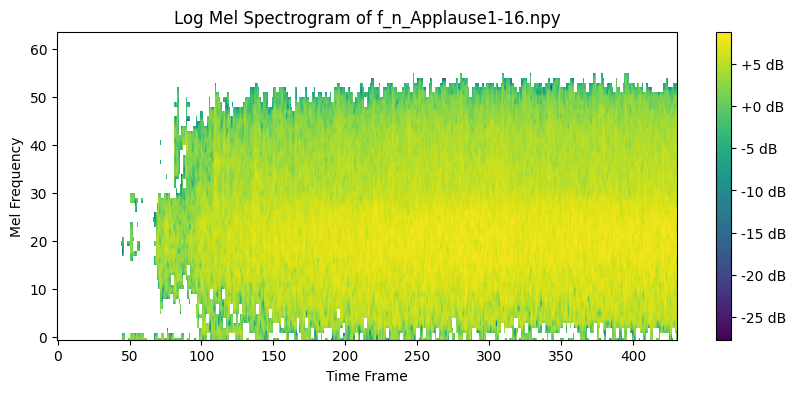

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Path to the processed directory
processed_dir = Path('/Users/nellygarcia/Documents/InformationRetrivalPhd/Dataset/Processed')

# Function to load and visualize a log Mel spectrogram
def visualize_spectrogram(file_path):
    # Load the log Mel spectrogram
    log_mel_spec = np.load(file_path)
    
    # Convert to decibels
    log_mel_spec_db = 10 * np.log10(log_mel_spec)
    
    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    plt.imshow(log_mel_spec_db[0, :, :], aspect='auto', origin='lower')
    plt.title(f'Log Mel Spectrogram of {file_path.name}')
    plt.ylabel('Mel Frequency')
    plt.xlabel('Time Frame')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

# Example usage
example_file = processed_dir / 'f_n_Applause1-16.npy'  # Replace with your .npy file
visualize_spectrogram(example_file)


Create a CSV

In [8]:

import pandas as pd
from pathlib import Path
import random
import numpy as np

# Define the processed directory
processed_dir = Path('/Users/nellygarcia/Documents/InformationRetrivalPhd/Dataset/Processed')

# List of available files
npy_files = list(processed_dir.glob('*.npy'))

# Extract unique class labels
class_labels = sorted(set(int(file.stem.split('-')[-1]) for file in npy_files))

# Create a mapping from class label to one-hot encoded vectors
class_to_onehot = {cls: np.eye(len(class_labels))[i] for i, cls in enumerate(class_labels)}

# Generate metadata
data = []
for file in npy_files:
    # Extract class from filename
    label = int(file.stem.split('-')[-1])
    
    # Get one-hot encoded label
    one_hot_label = class_to_onehot[label].tolist()
    
    # Randomly assign split (70% train, 20% test, 10% val)
    split = random.choices(['train', 'test', 'val'], [0.7, 0.2, 0.1])[0]
    
    data.append({'filename': file.name, 'split': split, 'label': one_hot_label})

# Create a DataFrame and save it as CSV
df = pd.DataFrame(data)
metadata_file = processed_dir / 'metadata.csv'
df.to_csv(metadata_file, index=False)

print("Metadata CSV created successfully.")



Metadata CSV created successfully.


In [6]:
#Allows dataset that are heavy but loading them in batches
#Creating data loader for train set
BATCH_SIZE=128
EPOCHS=10
LEARNING=.001
train_data_loader=DataLoader(train_data,batch_size=BATCH_SIZE)
if torch.cuda.is_available():
    device="cuda"
else:
    device="cpu"
print(f"Using {device}device")
feed_forward_net=FeedForwardNet().to(device)#assign model to device CUDA OR CPU . GPU=CUDA

#LOOS FUNCTION
loss_fn=nn.CrossEntropyLoss()
optimiser= torch.optim.Adam(feed_forward_net.parameters(),lr=LEARNING)
#Train MODEL
train(feed_forward_net,train_data_loader,loss_fn,optimiser, device,EPOCHS)
#Store the model
torch.save(feed_forward_net.state_dict(), "feedforwardnet.pth")
print("Model Trained and stored at feedforwardnet.pth")

Using cpudevice
Epoch 1
Loss1.513630986213684
-------------
Epoch 2
Loss1.4929240942001343
-------------
Epoch 3
Loss1.495730996131897
-------------
Epoch 4
Loss1.4805536270141602
-------------
Epoch 5
Loss1.4748631715774536
-------------
Epoch 6
Loss1.4730768203735352
-------------
Epoch 7
Loss1.4725065231323242
-------------
Epoch 8
Loss1.4724150896072388
-------------
Epoch 9
Loss1.4723429679870605
-------------
Epoch 10
Loss1.4722328186035156
-------------
Training is done
Model Trained and stored at feedforwardnet.pth
